# Part I: Window-based stereo

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import LogNorm
from skimage import img_as_ubyte

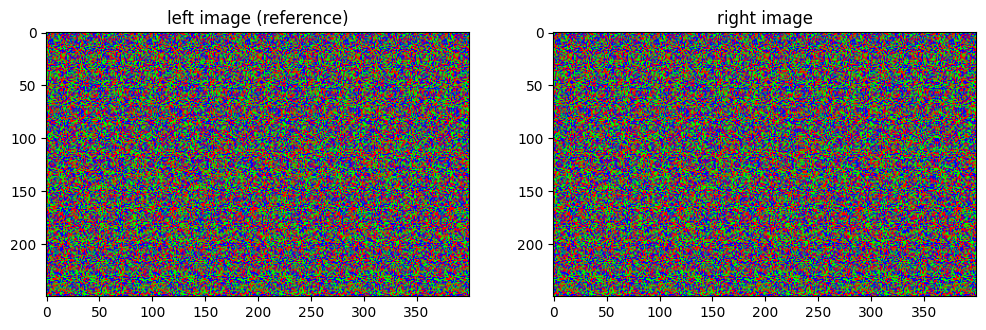

In [3]:
# random dot stereo pair for code developing/testing
im_left = image.imread("images/stereo_pairs/rds_left.gif")
im_right = image.imread("images/stereo_pairs/rds_right.gif")

fig = plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(122)
plt.title("right image")
plt.imshow(im_right)

# the range of disparities for this random dot stereo pair 
d_min = 0
d_max = 2

### We can compute and visualize an array of "squared differences" between RGB pixel values in the left and the right images. Each RGB pixel value is treated as a 3-vector and "squared difference" is interpreted as the squared L2 norm of the difference between the corresponding vectors. 

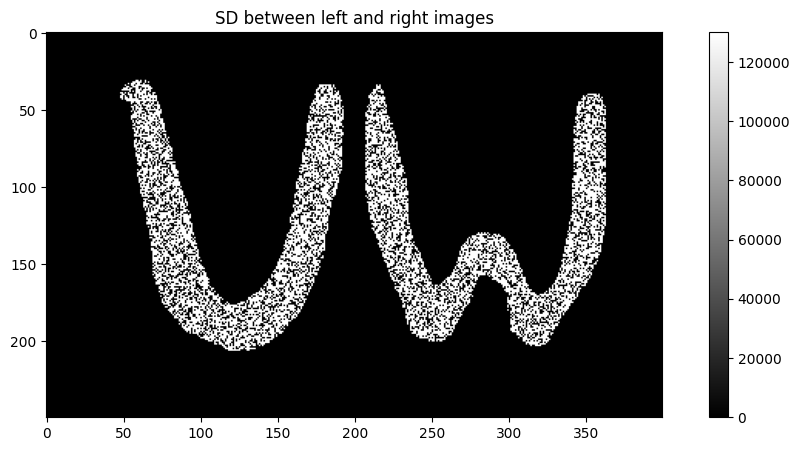

In [4]:
# initialize SD matrix to 0
SD = np.zeros(np.shape(im_left)) 

# compute difference for all 3 channels
D_R = abs(im_left[:, :, 0].astype(np.float64) - im_right[:, :, 0].astype(np.float64))
D_G = abs(im_left[:, :, 1].astype(np.float64) - im_right[:, :, 1].astype(np.float64))
D_B = abs(im_left[:, :, 2].astype(np.float64) - im_right[:, :, 2].astype(np.float64))

# compute squared difference
SD = ((D_R ** 2) + (D_G ** 2) + (D_B ** 2)).astype(np.float64)

# plot
fig = plt.figure(figsize = (12, 5))
plt.title("SD between left and right images")
plt.imshow(SD, cmap = "gray")
plt.colorbar()

### Below is a function for computing squared differences between RGB pixel values in the reference (left) image and the "shifted" right image for ALL shifts/disparities $\Delta$ in the range $\Delta\in [d_{min},d_{max}]$. The output is array $SD$ such that $SD[i]$ is an image of Squared Differences for shift $\Delta = d_{min} + i$ for any $i\in [0,d_{max}-d_{min}]$. 

In [5]:
def SD_array(imageL, imageR, d_minimum, d_maximum, left_ref=True):
    # initialization of the array of "squared differences" for different shifts
    SD = np.zeros((1+d_maximum-d_minimum, np.shape(imageL)[0], np.shape(imageL)[1]))
    
    # if left_ref is true, set left image as the reference
    # else, set right image as the reference
    ref_image = imageL if left_ref else imageR
    second_image = imageR if left_ref else imageL
    
    # iterate over disparities
    for d in range(d_minimum, d_maximum+1):
        # if left image is the reference, shift right by the disparity value
        # if right image is the reference, shift left by the disparity value
        shift = d if left_ref else -d
        image_shifted = np.roll(second_image, shift, axis=1)
        
        # compute differences
        D_R = (ref_image[:, :, 0].astype(np.float64) - image_shifted[:, :, 0].astype(np.float64))
        D_G = (ref_image[:, :, 1].astype(np.float64) - image_shifted[:, :, 1].astype(np.float64))
        D_B = (ref_image[:, :, 2].astype(np.float64) - image_shifted[:, :, 2].astype(np.float64))

        # compute squared difference
        SD[d-d_minimum] = ((D_R ** 2) + (D_G ** 2) + (D_B ** 2)).astype(np.float64)
        
    # remove first d columns from array because they have no logical meaning
    SD = SD[:, :, d:]
    
    return SD

### We can now use the $\text{SD_array}$ function to compute SD images for the random dot stereo pair.

(250, 400, 4)
(250, 400, 4)
(3, 250, 398)


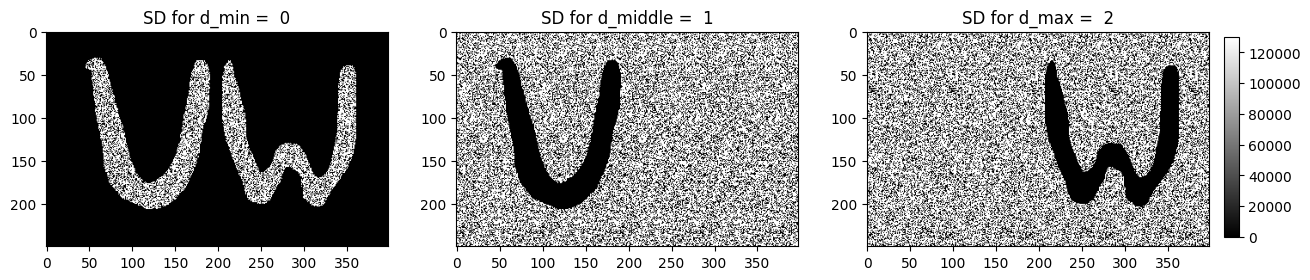

In [6]:
SD = SD_array(im_left, im_right, d_min, d_max)    
print(np.shape(im_left))
print(np.shape(im_right))
print(np.shape(SD))

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(SD[d_max-d_min], cmap = "gray")
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.01, 0.5]))

### Below is a function to compute an "integral image" for any given "scalar" image.

In [7]:
def integral_image(img):
    # initialize integral image with zeros
    integral_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.float64)
    
    # set first column equal to values from image
    integral_img[:, 0] = img[:, 0]
    
    # set each column in integral image equal to value in image 
    # plus value in previous column of integral image
    for col in range(1, img.shape[1]):
        integral_img[:, col] = img[:, col] + integral_img[:, col-1]
            
    # set each row in integral image equal to value in integral image 
    # plus value in previous row of integral image
    for row in range(1, img.shape[0]):
        integral_img[row, :] = integral_img[row, :] + integral_img[row-1, :]
    
    return integral_img

### We apply the $\text{intergal_image}$ function to the "squared differences" (SD) for each disparity.

(3, 250, 398) (3, 250, 398)


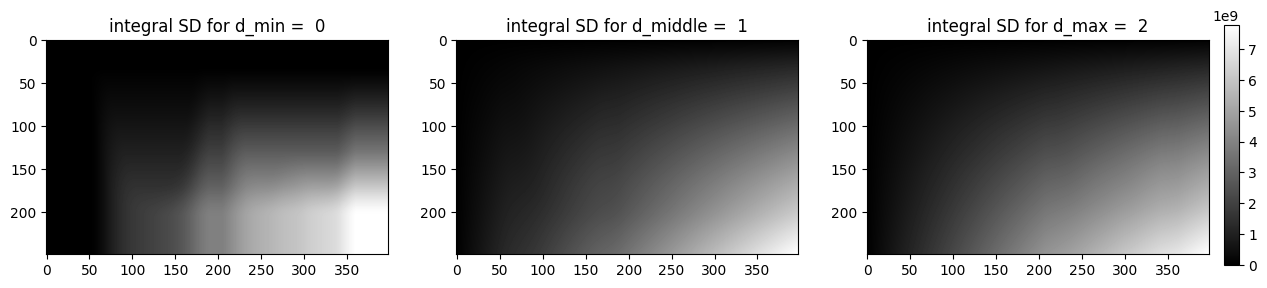

In [8]:
integral_SD = np.zeros(np.shape(SD))
print(np.shape(integral_SD),np.shape(SD))

for Delta in range(1+d_max-d_min):
    integral_SD[Delta] = integral_image(SD[Delta])

fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('integral SD for d_min = {:>2d}'.format(d_min))
plt.imshow(integral_SD[0], cmap = "gray")
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('integral SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(integral_SD[d_middle-d_min], cmap = "gray")
plt.subplot(133)
plt.title('integral SD for d_max = {:>2d}'.format(d_max))
plt.imshow(integral_SD[d_max-d_min], cmap = "gray")
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

### The function below sums the elements of the input image within fixed-size windows around image pixels. Note that this function works for any (odd or even) values of the parameter $\text{window_width}\in\{1,2,3,4,5,...\}$ according to the windows illustration below: <img src="images\windows.png">

In [9]:
import math
INFTY = np.inf

def windSum(img, window_width):
    # initialize summed image to infinity
    summed_img = np.matrix(np.ones((img.shape[0], img.shape[1])) * INFTY)
    
    # get integral image
    integral_img = integral_image(img)

    # set coordinates of bottom row, right column, 
    # top row (above image), and left column (beside image)
    b_row = int(math.floor(window_width / 2.0))
    r_col = int(math.floor(window_width / 2.0))
    t_row = b_row - window_width
    l_col = r_col - window_width
    
    # create shifted image for bottom right, top left, 
    # bottom left, and top right pixels in window
    br_shifted_img = np.roll(np.roll(integral_img, -b_row, axis=0), -r_col, axis=1)
    tl_shifted_img = np.roll(np.roll(integral_img, -t_row, axis=0), -l_col, axis=1)
    bl_shifted_img = np.roll(np.roll(integral_img, -b_row, axis=0), -l_col, axis=1)
    tr_shifted_img = np.roll(np.roll(integral_img, -t_row, axis=0), -r_col, axis=1)
    
    # calculate sum of window
    summed_img = br_shifted_img - bl_shifted_img - tr_shifted_img + tl_shifted_img
    
    # fill margins at half window width (rounded up) to infinity
    half_window_width = int(math.ceil(window_width / 2.0))
    summed_img[:half_window_width, :] = INFTY
    summed_img[-half_window_width:, :] = INFTY
    summed_img[:, :half_window_width] = INFTY
    summed_img[:, -half_window_width:] = INFTY

    return summed_img

### SSD images for windows of different widths and for different disparities are computed by applying the $\text{windSum}$ function to the "squared differences" SD.

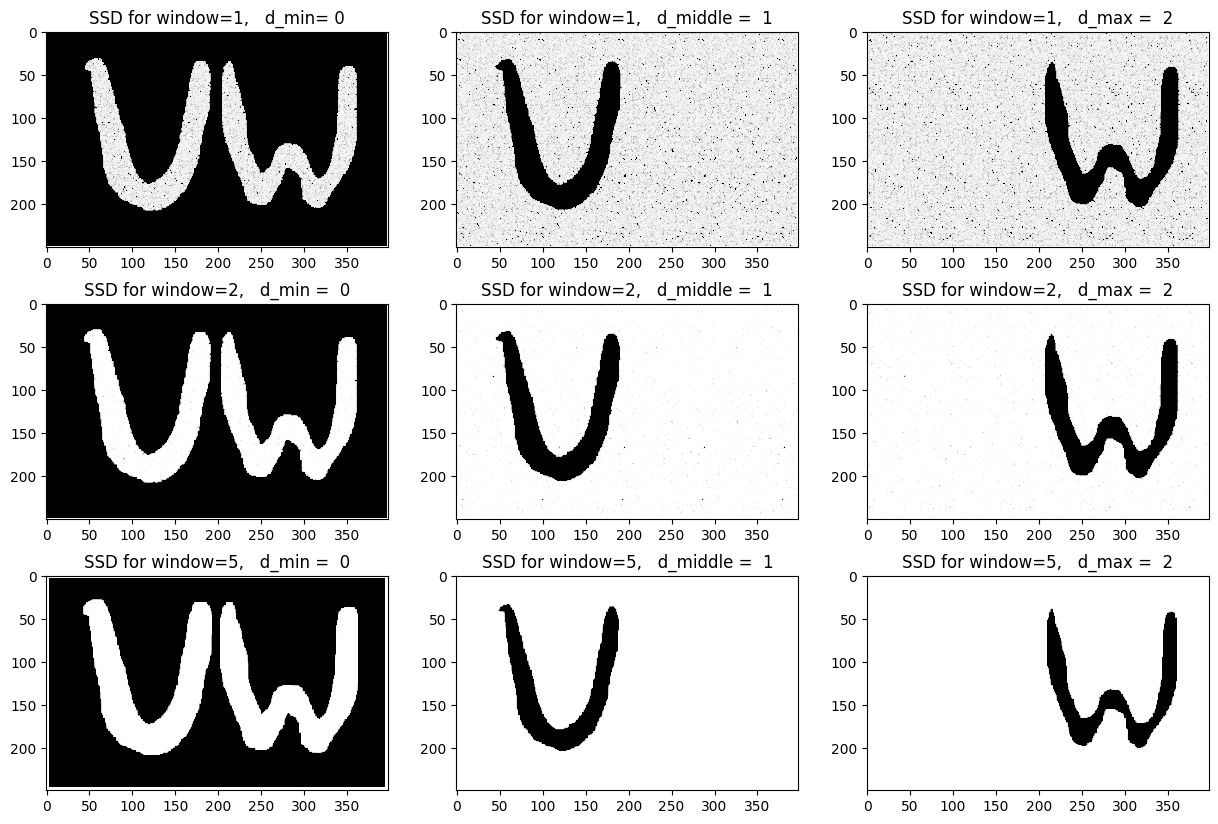

In [10]:
SSD1 = np.zeros(np.shape(SD))
SSD2 = np.zeros(np.shape(SD))
SSD5 = np.zeros(np.shape(SD))

for Delta in range(1+d_max-d_min):
    SSD1[Delta] = windSum(SD[Delta],1)
    SSD2[Delta] = windSum(SD[Delta],2)
    SSD5[Delta] = windSum(SD[Delta],5)
    
d_middle = round((d_min+d_max)/2)
        
fig = plt.figure(figsize = (15, 10))
plt.subplot(331)
plt.title('SSD for window=1,   d_min={:>2d}'.format(d_min))
plt.imshow(1+SSD1[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(332) 
plt.title('SSD for window=1,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD1[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(333)
plt.title('SSD for window=1,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD1[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(334)
plt.title('SSD for window=2,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD2[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(335) 
plt.title('SSD for window=2,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD2[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(336)
plt.title('SSD for window=2,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD2[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(337)
plt.title('SSD for window=5,   d_min = {:>2d}'.format(d_min))
plt.imshow(1+SSD5[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(338) 
plt.title('SSD for window=5,   d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SSD5[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(339)
plt.title('SSD for window=5,   d_max = {:>2d}'.format(d_max))
plt.imshow(1+SSD5[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))

### The function below computes a "disparity map" from SSD arrays (as above) for each disparity in the range specified by the integers $d_{min}$, $d_{max}$. It returns a disparity map (image). At each pixel, the disparity map image has a disparity value corresponding to the minimum SSD at this pixel. For pixels at the margins, the disparity map is set to zero.

In [11]:
def SSDtoDmap(SSD_array, d_minimum, d_maximum):
    # initialize d_minimum as best disparity for all pixels
    dMap = np.full(np.shape(SD[0]), d_minimum)
    best_ssd = SSD_array[0]
    
    # wherever SSD is infinity (margins), replace SSD and disparity with 0
    dMap = np.where(np.isinf(best_ssd), 0, d_minimum)
    best_ssd = np.where(np.isinf(best_ssd), 0.0, best_ssd)
    
    # iterate over disparities
    for d in range(d_minimum+1, d_maximum+1):
        # create SSD and disparity arrays for current d
        current_ssd = SSD_array[d-d_minimum]
        current_disparity = np.full(np.shape(SD[0]), d)
        
        # wherever SSD is infinity (margins), replace SSD and disparity with 0
        current_disparity = np.where(np.isinf(current_ssd), 0, d)
        current_ssd = np.where(np.isinf(current_ssd), 0.0, current_ssd)

        # for each pixel, check if SSD is better at lowest SSD or current SSD
        temp_best_ssd = best_ssd
        new_best_ssd = np.where(best_ssd < current_ssd, best_ssd, current_ssd)
        new_dMap = np.where(best_ssd < current_ssd, dMap, current_disparity)
        
        # update new best SSD and disparity
        best_ssd = new_best_ssd
        dMap = new_dMap

    return dMap

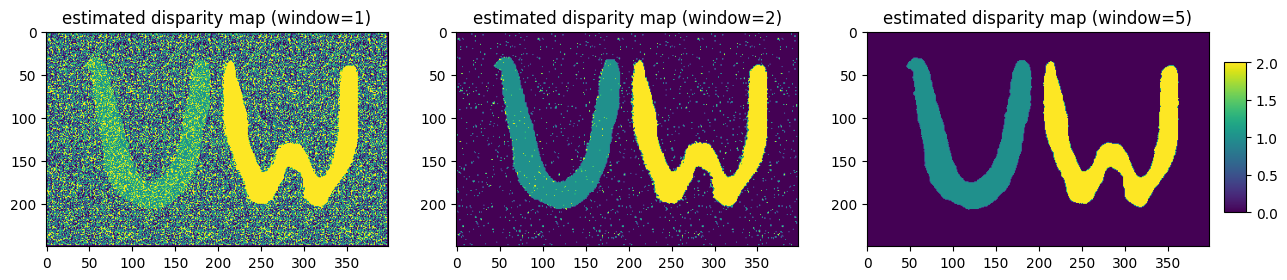

In [12]:
dMap1 = SSDtoDmap(SSD1,d_min,d_max)
dMap2 = SSDtoDmap(SSD2,d_min,d_max)
dMap5 = SSDtoDmap(SSD5,d_min,d_max)

fig = plt.figure(figsize = (15, 3))
plt.subplot(131)
plt.title("estimated disparity map (window=1)")
plt.imshow(dMap1, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("estimated disparity map (window=2)")
plt.imshow(dMap2, vmin = 0, vmax = d_max)
plt.subplot(133)
plt.title("estimated disparity map (window=5)")
plt.imshow(dMap5, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.25, 0.015, 0.5]))

### The code below tests these algorithms on a real stereo pair with ground truth (Tsukuba dataset).

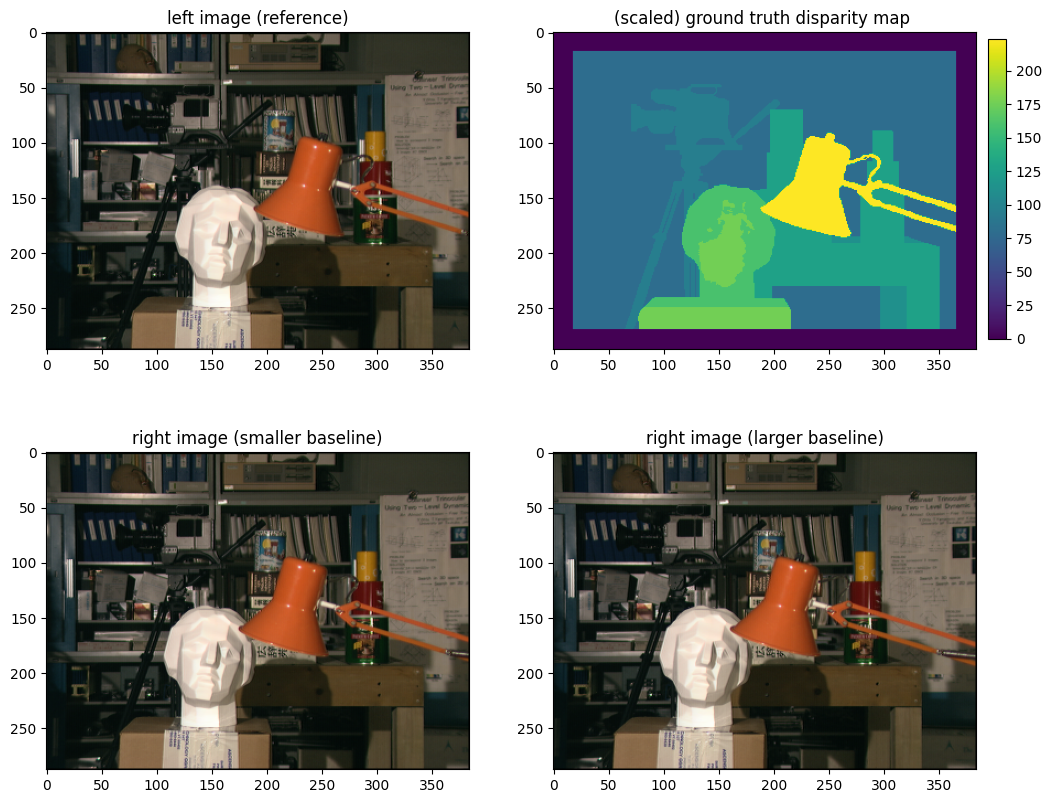

In [13]:
im_left = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col3.ppm")
im_gt = image.imread("images/stereo_pairs/tsukuba/truedisp.row3.col3.pgm")
im_right = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col4.ppm")
im_right2 = image.imread("images/stereo_pairs/tsukuba/scene1.row3.col5.ppm")

fig = plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title("left image (reference)")
plt.imshow(im_left)
plt.subplot(222) 
plt.title("(scaled) ground truth disparity map ")
plt.imshow(im_gt)
plt.colorbar(cax=plt.axes([0.91, 0.557, 0.015, 0.3]))
plt.subplot(223)
plt.title("right image (smaller baseline)")
plt.imshow(im_right)
plt.subplot(224)
plt.title("right image (larger baseline)")
plt.imshow(im_right2)

### Using ground truth disparity map, we can estimate the range of disparity values between pixels in the left image ($\text{im_left}$) and the right image ($\text{im_right}$) .

In [14]:
# unscale image
unscaled_im_gt = im_gt / 16

# get minimum non-zero value
d_min = int(np.amin(unscaled_im_gt[np.nonzero(unscaled_im_gt)]))

# get maximum value
d_max = int(np.amax(unscaled_im_gt))

print(d_min, d_max)

5 14


### We can compute the squared differences using the $\text{SD_array}$ function and visualize the results using a logarithmic scale. A linear scale would make it hard to see smaller squared differences since there are many very large ones.

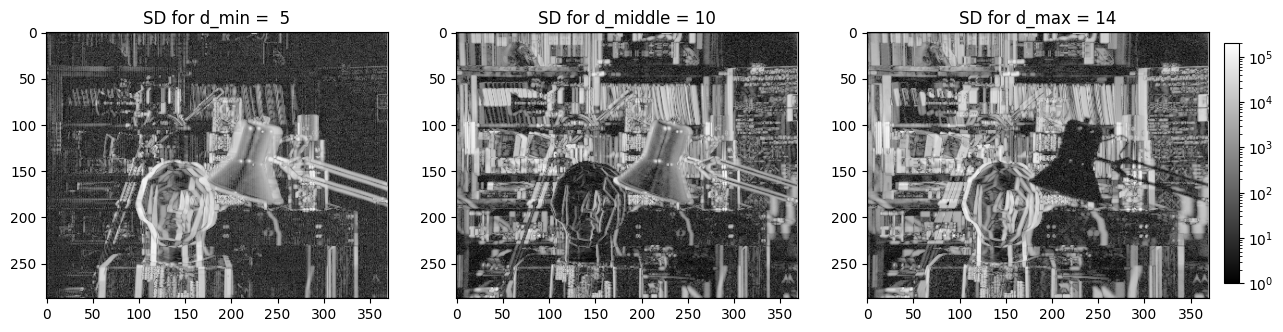

In [15]:
SD = SD_array(im_left, im_right, d_min, d_max)    
fig = plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.title('SD for d_min = {:>2d}'.format(d_min))
plt.imshow(im_left)
plt.imshow(1+SD[0], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(132) 
d_middle = round((d_min+d_max)/2)
plt.title('SD for d_middle = {:>2d}'.format(d_middle))
plt.imshow(1+SD[d_middle-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.subplot(133)
plt.title('SD for d_max = {:>2d}'.format(d_max))
plt.imshow(1+SD[d_max-d_min], cmap = "gray", norm=LogNorm(vmin=1, vmax=200000))
plt.colorbar(cax=plt.axes([0.91, 0.2, 0.01, 0.6]))

In the plot on the left, the objects in the background appear darker while objects closer to the foreground appear lighter. The plot on the right has the opposite result. This occurs because objects with a lower depth have a higher disparity, so the sum of squared differences will be lowest when the disparity is high. This is why the lamp has a low sum of squared differences in the right plot, making it appear darker. In the left plot, which has a low disparity, the lamp appears lighter as the sum of squared differences is higher.

In general, closer objects will appear darker when the disparity is high and lighter when the disparity is low. The reverse is true for farther objects.

### The function $\text{Dmap_Windows}$ returns a disparity map from a given stereo pair (left and right image), specified disparity range, and window size.

In [16]:
def Dmap_Windows(imageL, imageR, d_minimum, d_maximum, window_width):
    # compute squared differences
    SD = SD_array(imageL, imageR, d_minimum, d_maximum)
    
    # initialize SSD array to zeros
    SSD = np.zeros(np.shape(SD))
    
    # compute sum of squared differences for window over all disparities
    for Delta in range(1+d_maximum-d_minimum):
        SSD[Delta] = windSum(SD[Delta], window_width)
    
    # compute disparity map
    dMap = SSDtoDmap(SSD, d_minimum, d_maximum)

    return dMap

### Disparity maps for the Tsukuba dataset are shown below using small and large windows.

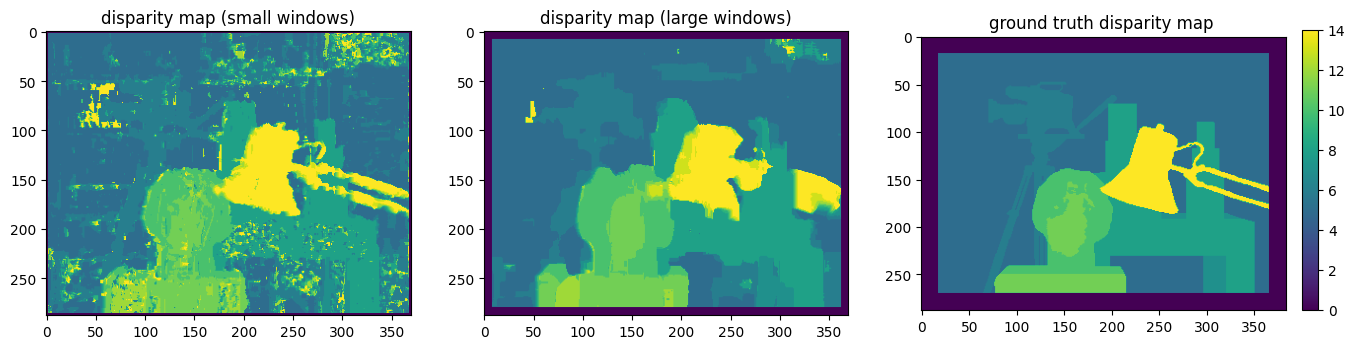

In [17]:
dispMap_small = Dmap_Windows(im_left, im_right, d_min, d_max, 4)
dispMap_large = Dmap_Windows(im_left, im_right, d_min, d_max, 15)

fig = plt.figure(figsize = (16, 7))
plt.subplot(131)
plt.title("disparity map (small windows)")
plt.imshow(dispMap_small, vmin = 0, vmax = d_max)
plt.subplot(132)
plt.title("disparity map (large windows)")
plt.imshow(dispMap_large, vmin = 0, vmax = d_max)
plt.subplot(133) 
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

# Scan-line stereo

### The $Viterbi$ approach is presented below and applied to the Tsukuba example. For the photo-consistency term  of the loss function (objective function), we use the previously implemented $\text{SD_array}$ $$D_p(d) = |I_p-I_{p+d}|^2 \;\;\;\;\;\longleftarrow\;\;\;\; \text{SD_array}[d][p] $$ that for every pixel $p$ defines the cost for every possible disparity value $d\in\{d_{min},...,d_{max}\}$. The regularization term is $$V_{pq}(d_p,d_q) = w|d_p-d_q|$$ where some value for parameter $w$ are selected empirically (starting from $w\approx 0$). 

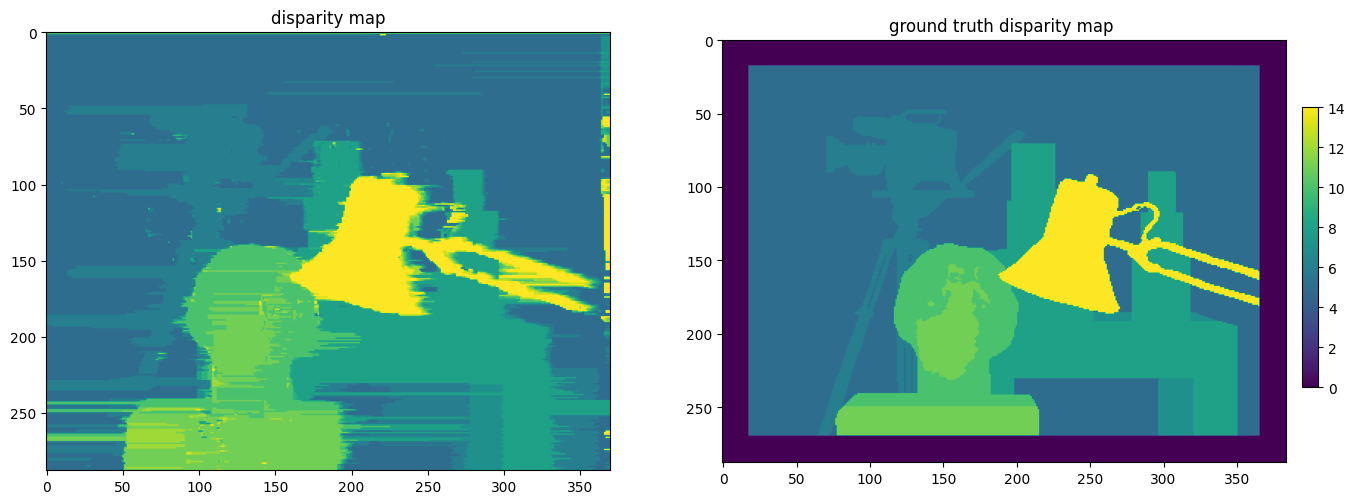

In [18]:
def Viterbi(imageL, imageR, d_min, d_max, photo_consistency, w):
    # create matrix of all disparities from d_min to d_max
    disparity = np.arange(d_min, d_max+1)

    # initialize E_bar matrix to zero
    # number of states = number of disparities (d_max - d_min + 1)
    # number of sites = number of pixels in scanline (cols of SD)
    num_states = d_max - d_min + 1
    E_bar = np.zeros((num_states, photo_consistency.shape[2]))
    
    # initialize path matrix to record state paths
    path = np.zeros((num_states, photo_consistency.shape[2]))
    
    # initialize disparity map to zero
    dMap = np.zeros((photo_consistency.shape[1], photo_consistency.shape[2]))

    # iterate over each scanline
    for scanline in range(photo_consistency.shape[1]):
        
        # iterate over each site
        for site in range(1, photo_consistency.shape[2]):
            
            # iterate over states of second site
            for site_2_state in range(num_states):
                
                # initialize matrix of possbile costs for state of second site
                possible_costs = np.zeros((num_states, 1))
                
                # compute possible costs
                possible_costs = compute_possible_costs(photo_consistency, scanline, site, w, 
                                                        disparity, site_2_state, E_bar)
                
                # update E_bar with minimum of possible costs
                E_bar[site_2_state, site] = min(possible_costs)

                # update path
                path[site_2_state, site] = np.argmin(possible_costs)
                
        # find index of minimum E_bar to get last state, then trace path back
        previous_state = np.argmin(E_bar[:, -1])
        list_of_states = [previous_state]
        
        # iterate backwards over path
        for i in range(path.shape[1]-1, 0, -1):
            previous_state = path[int(previous_state), i]
            list_of_states.append(previous_state)
            
        # update scan-line in disparity map with path reversed
        # add d_min to convert from state index to disparity value
        dMap[scanline] = np.flip(np.asarray(list_of_states)) + d_min
        
    return dMap


# compute possible costs for the site 2 state: E(site_1_state, site_2_state) + E_bar(site_1_state)
# where E is sum of regularization and photo consistency terms
def compute_possible_costs(photo_consistency, scanline, site, w, disparity, site_2_state, E_bar):
    regularization = w * abs(disparity - disparity[site_2_state])
    return photo_consistency[:, scanline, site-1] + regularization + E_bar[:, site-1]


# set regularization parameter
w = 500

# generate photo consistency for all pixels at all disparities
photo_consistency = SD_array(im_left, im_right, d_min, d_max, left_ref=False)

# generate disparity map
dispMap = Viterbi(im_left, im_right, d_min, d_max, photo_consistency, w)

# plot
fig = plt.figure(figsize = (16, 7))
plt.subplot(121)
plt.title("disparity map")
plt.imshow(dispMap, vmin = 0, vmax = d_max)
plt.subplot(122)
plt.title("ground truth disparity map ")
plt.imshow(im_gt/16, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

In general, the disparity map here is improved compared to the window-based approach. Scan-line stereo does not have the issue of noise that occurs with small windows, nor does it have the blurring of boundaries that occurs with large windows. However, some streaking artifacts are noticeable.

### Problem 7(b): Test the case where the photoconsistency term $D_p(d)$ is computed by averaging SD in some small window of size $h$. That is, for each disparity $d$ you should replace 2D array $\text{SD_array}(d)$ in Problem 7(a) by $$\text{SD_array}(d)   \;\;\;\;\;\longleftarrow\;\;\;\;  windSum(SD(d),h).$$ Compare the results for different window sizes $h\in\{1,3,5\}$. Feel free to fine tune regularization parameter $w$ for each case trying to obtain the best results possible. 
### NOTE 1: $h=1$ should be equivalent to Problem 7(a) above. 
### NOTE 2: this version combines window-based stereo with regularization along scan-lines. The case when $w=0$ should give the same results as in Problem 6(c).  

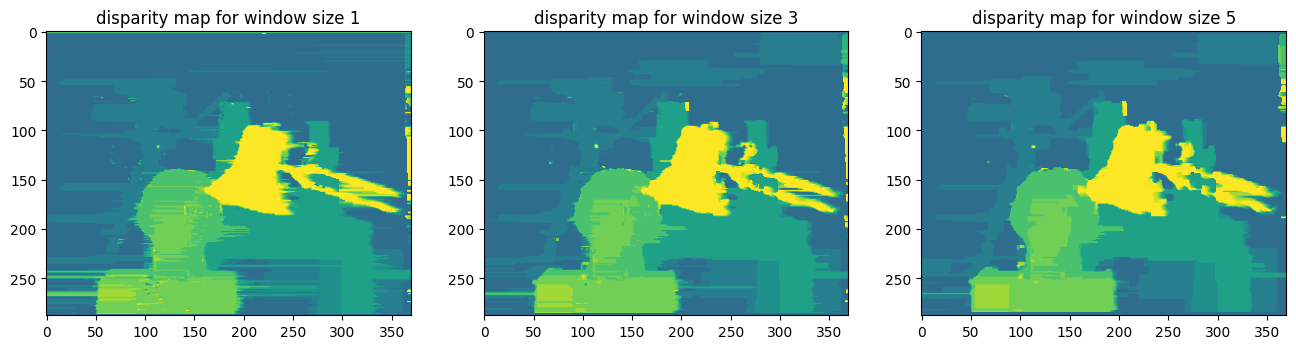

In [19]:
# calculate squared differences
SD = SD_array(im_left, im_right, d_min, d_max, left_ref=False)

# set w and window size values
w = np.array([500, 1500, 3000])
window_size = np.array([1, 3, 5])

# create figure
fig = plt.figure(figsize = (16, 7))

# iterate over 3 window sizes
for i in range(3):
    # iterate over disparities
    for d in range(d_max-d_min+1):
        # calculate photo consistency in window
        photo_consistency[d] = windSum(SD[d], window_size[i])
        # replace infinite photo consistencies with 0
        photo_consistency[d] = np.where(np.isinf(photo_consistency[d]), 0, photo_consistency[d])
        
    # compute disparity map
    dispMap = Viterbi(im_left, im_right, d_min, d_max, photo_consistency, w[i])
    
    # plot
    plt.subplot(131+i)
    plt.title(str("disparity map for window size " + str(window_size[i])))
    plt.imshow(dispMap, vmin = 0, vmax = d_max)

Compared to window-based stereo, this approach has less blurry boundaries for large window sizes as the scanlines are being analyzed coherently. The streaking artifacts are also reduced compared to the approach without windows. In particular, the large window size has the least amount of streaking.

### Below, we test the performance for quadratic and (robust) truncated-quadratic regularization terms $$V_{pq}(d_p,d_q) = w|d_p-d_q|^2\;\;\;\text{and}\;\;\;\;V_{pq}(d_p,d_q) = min\{w|d_p-d_q|^2,T\}.$$

In [ ]:
# set regularization parameter
w = 10000

# reaplce cost function with quadratic regularization
def compute_possible_costs(photo_consistency, scanline, site, w, disparity, site_2_state, E_bar):
    regularization = w * (disparity - disparity[site_2_state])**2
    return photo_consistency[:, scanline, site-1] + regularization + E_bar[:, site-1]

# compute quadratic disparity map
dispMap_quadratic = Viterbi(im_left, im_right, d_min, d_max, photo_consistency, w)

# replace cost function with truncated quadratic regularization
def compute_possible_costs(photo_consistency, scanline, site, w, disparity, site_2_state, E_bar):
    # use threshold of 20000
    regularization = np.where(w * (disparity - disparity[site_2_state])**2 < 20000,
                              w * (disparity - disparity[site_2_state])**2, 20000)
    return photo_consistency[:, scanline, site-1] + regularization + E_bar[:, site-1]

# compute truncated quadratic disparity map
dispMap_truncated = Viterbi(im_left, im_right, d_min, d_max, photo_consistency, w)

# plot
fig = plt.figure(figsize = (16, 7))
plt.subplot(121)
plt.title("quadratic regularization disparity map")
plt.imshow(dispMap_quadratic, vmin = 0, vmax = d_max)
plt.subplot(122)
plt.title("truncated quadratic regularization disparity map")
plt.imshow(dispMap_truncated, vmin = 0, vmax = d_max)
plt.colorbar(cax=plt.axes([0.91, 0.3, 0.01, 0.4]))

The unbounded quadratic regularization can result in a large amount of streaking because the penalty for disparity changes is higher. The truncated regularization has noticeably sharper edges and less streaking than the unbounded regularization because it has a bound on how high the disparity change penalty can be.